# DonorsChoose Application Screening

Data Source: https://www.kaggle.com/c/donorschoose-application-screening

# Introduction

#### About DonorsChoose:<br>

Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

#### Their Mission:<br>

They make it easy for anyone to help a classroom in need, moving them closer to a nation where students in every community have the tools and experiences they need for a great education.

#### Objective:<br>

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

# About Data

The dataset contains information from teachers' project applications to DonorsChoose.org including teacher attributes, school attributes, and the project proposals including application essays.

#### Files:<br>
Data is provided in Two Files:<br>
<ul>
    <li>train.csv - the training set</li>
    <li>resources.csv - resources requested by each proposal; joins with train.csv on id</li>
</ul>

#### Data Fields:<br>

##### Train Data Fields

<ul>
<li><strong>id</strong> - unique id of the project application</li>
<li><strong>teacher_id</strong>&nbsp;- id of the teacher submitting the application</li>
<li><strong>teacher_prefix</strong>&nbsp;- title of the teacher's name (Ms., Mr., etc.)</li>
<li><strong>school_state</strong>&nbsp;- US state of the teacher's school</li>
<li><strong>project_submitted_datetime</strong>&nbsp;- application submission timestamp</li>
<li><strong>project_grade_category</strong>&nbsp;- school grade levels (PreK-2, 3-5, 6-8, and 9-12)</li>
<li><strong>project_subject_categories</strong>&nbsp;- category of the project (e.g., "Music &amp; The Arts")</li>
<li><strong>project_subject_subcategories</strong>&nbsp;- sub-category of the project (e.g., "Visual Arts")</li>
<li><strong>project_title</strong>&nbsp;- title of the project</li>
<li><strong>project_essay_1</strong>&nbsp;- first essay<sup>*</sup></li>
<li><strong>project_essay_2</strong>&nbsp;- second essay<sup>*</sup></li>
<li><strong>project_essay_3</strong>&nbsp;- third essay<sup>*</sup></li>
<li><strong>project_essay_4</strong>&nbsp;- fourth essay<sup>*</sup></li>
<li><strong>project_resource_summary</strong>&nbsp;- summary of the resources needed for the project</li>
<li><strong>teacher_number_of_previously_posted_projects</strong>&nbsp;- number of previously posted applications by the submitting teacher</li>
<li><strong>project_is_approved</strong>&nbsp;- whether DonorsChoose proposal was accepted (0="rejected", 1="accepted"); <code>train.csv</code> only</li>
</ul>


<ul>
<li><strong>project_essay_1</strong>: "Introduce us to your classroom"</li>
<li><strong>project_essay_2</strong>: "Tell us more about your students"</li>
<li><strong>project_essay_3</strong>: "Describe how your students will use the materials you're requesting"</li>
<li><strong>project_essay_4</strong>: "Close by sharing why your project will make a difference"</li>
</ul>



<p>Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:</p>

<ul>
<li><strong>project_essay_1</strong>: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li><strong>project_essay_2</strong>: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
</ul>


##### Resources Data Fields

<ul>
<li><strong>id</strong> - unique id of the project application; joins with <code>train.csv</code> on <code>id</code></li>
<li><strong>description</strong> - description of the resource requested</li>
<li><strong>quantity</strong> - quantity of resource requested</li>
<li><strong>price</strong> - price of resource requested</li>
</ul>


## Loading Data

In [1]:
%matplotlib inline
from datetime import datetime

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings("ignore")

import pickle
import re

import string
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.preprocessing import scale,StandardScaler

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn import tree
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [4]:
train_df.shape

(182080, 16)

In [5]:
resource_df = pd.read_csv('resources.csv')

In [6]:
resource_df.shape

(1541272, 4)

### Merging Train Data with Resource

In [7]:
train_res_df = pd.merge(train_df,resource_df,on='id',how='left')

In [8]:
train_res_df.shape

(1081830, 19)

> Observation: There are around __10lakh__ data points with __19 features__ in the training data

# Exploratory Data Analysis(EDA)

In [9]:
train_res_df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,Apple - iPod nano� 16GB MP3 Player (8th Genera...,3,149.99
1,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,Apple - iPod nano� 16GB MP3 Player (8th Genera...,3,149.99
2,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,20,20.00
3,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,3doodler Start Full Edu Bundle,1,469.99
4,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,BALL PG 4'' POLY SET OF 6 COLORS,1,18.95


## Percentage of Projects Approved/Rejected

In [10]:
approved_percent = train_res_df[train_res_df['project_is_approved']==1].shape[0]/train_res_df.shape[0]*100;
print("Percentage of Approved Projects: ",approved_percent)
print("Percentage of Rejected Projects: ",100-approved_percent)

Percentage of Approved Projects:  79.23777303273157
Percentage of Rejected Projects:  20.762226967268433


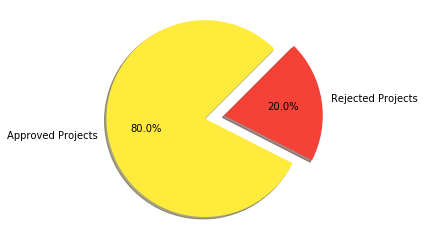

In [11]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Approved Projects', 'Rejected Projects'
slices_hours = [9.6, 2.4]
colors = ['#FFEB3B','#f44336']
explode = (0.2, 0)  # explode 1st slice
 
# Plot
plt.pie(slices_hours, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=45)
 
plt.axis('equal')
plt.show()

>Observation: Around __80%__ of submitted projects were __Approved__.<br>
Its an __"Imbalanced"__ DataSet

## Data Cleaning 

### Missing Data

In [12]:
# sum of rows containing null values 
total_NaN_rows = train_res_df[['project_essay_3','project_essay_4','description']].isnull().sum()
percent = (total_NaN_rows/train_res_df[['project_essay_3','project_essay_4','description']].isnull().count()*100)
missing_train_data  = pd.concat([total_NaN_rows, percent], axis=1, keys=['Total_NaN_rows', 'Percent'])
missing_train_data.head()

,Total_NaN_rows,Percent
project_essay_3,1043673,96.472921
project_essay_4,1043673,96.472921
description,192,0.017748


> Observation: Over __96%__ of the rows __dont have Data for Columns project_essay_3 and project_essay_4__ so lets ignore these Columns

#### Removing the above columns

In [13]:
train_df = train_df.drop(['project_essay_3','project_essay_4'],axis=1)


train_res_df = train_res_df.drop(['project_essay_3','project_essay_4'],axis=1)

### Removing Duplicate Rows if Any

In [14]:
train_res_df.shape

(1081830, 17)

In [15]:
train_res_df.duplicated().sum()

8576

> Observation: There are 8576 Duplicated rows in our training data

In [16]:
train_res_df.loc[train_res_df.duplicated(),:][0:5]

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
148,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,My students need access to quality replacement...,3,1,Tenor Saxophone Reeds,1,20.95
153,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,My students need access to quality replacement...,3,1,Traditional Bb Clarinet Reeds,6,21.95
394,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.70
469,p192882,d36c158f9f95db287dc019fe6f00cdad,Mrs.,WI,2016-08-20 11:27:08,Grades PreK-2,Health & Sports,Health & Wellness,Learn and Move,As a teacher in a low-income/high poverty scho...,This past year I noticed how wiggly my student...,"My students need Hokk chairsi, wobble chairs a...",0,0,Norwood Commercial Furniture NOR-STOOLBS-SO Pl...,1,48.95
740,p240306,1ee0a12eeb5da1c2fb438c682c8177dc,Mrs.,GA,2017-03-02 16:57:41,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Create - Evaluate - Celebrate,CREATE - EVALUATE - CELEBRATE!!!!\r\nEach chil...,Osmo states that it enables the iPad to merge ...,My students need to be challenged using techno...,2,1,Osmo Starter Kit,1,79.99


> Observation: These are the sum of the duplicate rows

In [17]:
train_res_df[(train_res_df['id']=='p160114') & (train_res_df['price']==32.7)]

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
393,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.7
394,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.7


> As we can see The above 2 rows are Exactly the same, We are removing these kind of rows.

##### Removing Duplicate rows

In [18]:
train_res_df=train_res_df.drop_duplicates(keep='first', inplace=False)
train_res_df.shape

(1073254, 17)

## Lets Understand the data

In [19]:
train_res_df['teacher_number_of_previously_posted_projects'].describe()

count    1.073254e+06
mean     1.256718e+01
std      3.042456e+01
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      4.510000e+02
Name: teacher_number_of_previously_posted_projects, dtype: float64

-> Observation: 
<ul>
    <li>Max no.of Projects Posted by a Teacher is 45</li>
    <li>75% of the Teachers have posted around 10 Projects</li>
</ul>


### Statewise Submissions

In [20]:
train_df =train_df.sort_values(by=['school_state'])

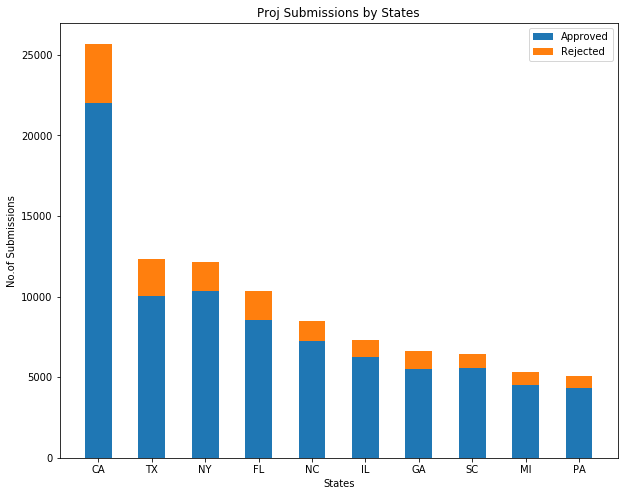

In [103]:
width = 0.5       # the width of the bars: can also be len(x) sequence
N = np.arange(10)
state_wise_count = train_df['school_state'].value_counts()
state_wise_count_approved = []
state_wise_count_rejected = []

for state in state_wise_count.index:
    state_wise_count_approved.append(np.sum(train_df["project_is_approved"][train_df["school_state"]==state] == 1))
    state_wise_count_rejected.append(np.sum(train_df["project_is_approved"][train_df["school_state"]==state] != 1))

    
plt.figure(figsize=(10,8))    
bar1 = plt.bar(N, state_wise_count_approved[0:10], width)
bar2 = plt.bar(N, state_wise_count_rejected[0:10], width,
             bottom=state_wise_count_approved[0:10])



plt.xticks(N,state_wise_count.index)

plt.title('Proj Submissions by States')
plt.xlabel('States')
plt.ylabel('No.of Submissions')

plt.legend((bar1[0], bar2[0]), ('Approved', 'Rejected'))

plt.show()

> Observation: We can observe that Submissions from __California__ is __More__ than other States.

### Count of Projs in each Category

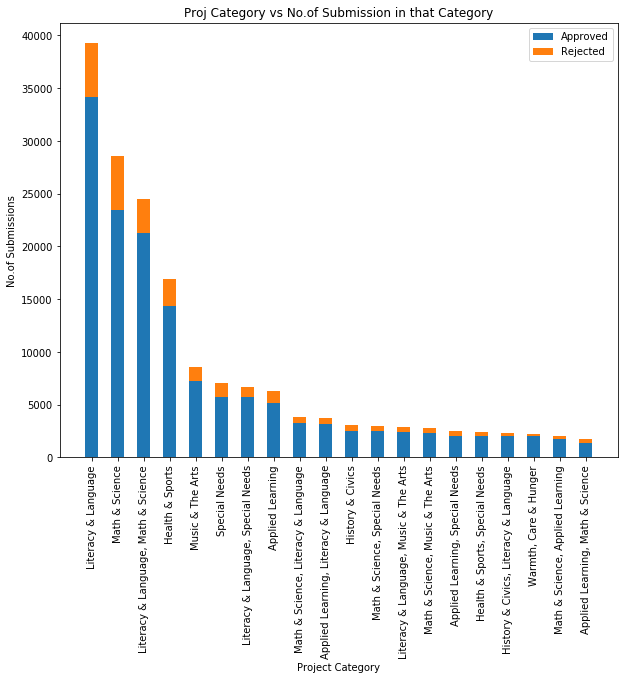

In [110]:
width = 0.5       
N = np.arange(20)
proj_wise_count = train_df['project_subject_categories'].value_counts()
proj_wise_count_approved = []
proj_wise_count_rejected = []

for proj in proj_wise_count.index:
    proj_wise_count_approved.append(np.sum(train_df["project_is_approved"][train_df["project_subject_categories"]==proj] == 1))
    proj_wise_count_rejected.append(np.sum(train_df["project_is_approved"][train_df["project_subject_categories"]==proj] != 1))

    
plt.figure(figsize=(10,8))    
bar1 = plt.bar(N, proj_wise_count_approved[0:20], width)
bar2 = plt.bar(N, proj_wise_count_rejected[0:20], width,
             bottom=proj_wise_count_approved[0:20])


plt.xticks(N,proj_wise_count.index,rotation=90)

plt.title('Proj Category vs No.of Submission in that Category')
plt.xlabel('Project Category')
plt.ylabel('No.of Submissions')

plt.legend((bar1[0], bar2[0]), ('Approved', 'Rejected'))

plt.show()


In [116]:
print('Percentage of Literacy & Language: ',(proj_wise_count.head(1).sum()/proj_wise_count.sum())*100)
print('Percentage of Top 10 projects: ',(proj_wise_count.head(10).sum()/proj_wise_count.sum())*100)
print('Percentage of Approval in the Top Project category: ',(proj_wise_count_approved[0]/proj_wise_count[0].sum())*100)

Percentage of Literacy & Language:  21.560303163444637
Percentage of Top 10 projects:  79.8643453427065
Percentage of Approval in the Top Project category:  86.98576050131187


> Observation: __Top 10 Projects__ Contribute __80%__ of total Submissions, among which __'Literacy & Language'__ Category Ranks 1st with __21%__ of which __87%__ of submissions were __Approved__.

### Count of Projs in each SubCategory

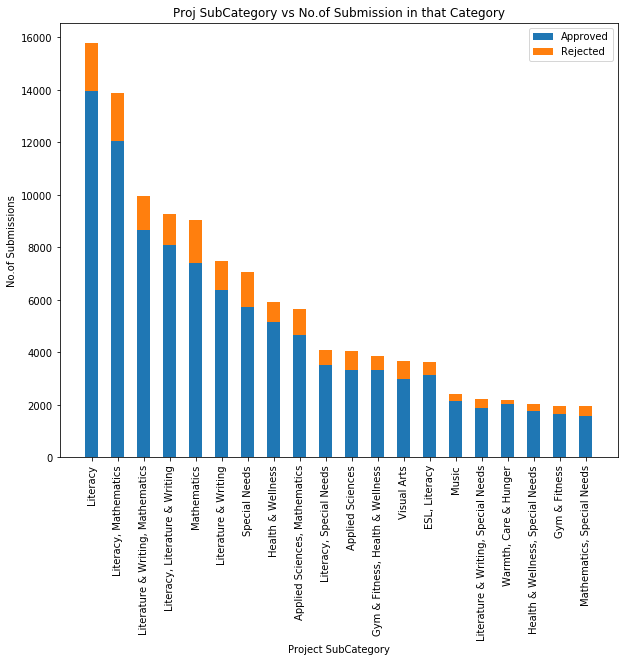

In [127]:
width = 0.5       
N = np.arange(20)
proj_subCatg_wise_count = train_df['project_subject_subcategories'].value_counts()
proj_subCatg_wise_count_approved = []
proj_subCatg_wise_count_rejected = []

for proj in proj_subCatg_wise_count.index:
    proj_subCatg_wise_count_approved.append(np.sum(train_df["project_is_approved"][train_df["project_subject_subcategories"]==proj] == 1))
    proj_subCatg_wise_count_rejected.append(np.sum(train_df["project_is_approved"][train_df["project_subject_subcategories"]==proj] != 1))

    
plt.figure(figsize=(10,8))    
bar1 = plt.bar(N, proj_subCatg_wise_count_approved[0:20], width)
bar2 = plt.bar(N, proj_subCatg_wise_count_rejected[0:20], width,
             bottom=proj_subCatg_wise_count_approved[0:20])


plt.xticks(N,proj_subCatg_wise_count.index,rotation=90)

plt.title('Proj SubCategory vs No.of Submission in that Category')
plt.xlabel('Project SubCategory')
plt.ylabel('No.of Submissions')

plt.legend((bar1[0], bar2[0]), ('Approved', 'Rejected'))

plt.show()


In [158]:
print('Percentage of Sub Category - Literacy: ',(proj_subCatg_wise_count.head(1).sum()/proj_subCatg_wise_count.sum())*100)
print('Percentage of Top 10 projects: ',(proj_subCatg_wise_count.head(10).sum()/proj_subCatg_wise_count.sum())*100)
print('Percentage of Approval in the Top Project SubCategory: ',(proj_subCatg_wise_count_approved[0]/proj_subCatg_wise_count[0].sum())*100)

Percentage of Sub Category - Literacy:  8.66377416520211
Percentage of Top 10 projects:  48.408391915641474
Percentage of Approval in the Top Project SubCategory:  88.40570522979398


> Observation: Here the distribution is widely spread among different SubCategories, among which __Literacy__ is in the __top place__ with __~9%__ of which __88% of submission__ in this category were __Approved__.  

### Lets see freq of Teacher no.of Previously Posted Projects

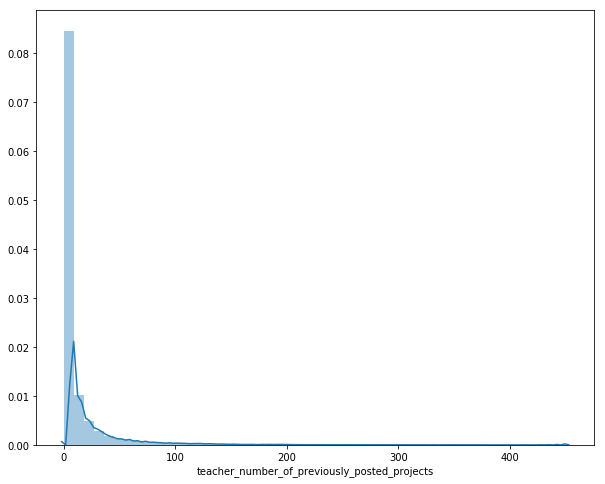

In [26]:
plt.figure(figsize=(10,8))
sns.distplot(train_df['teacher_number_of_previously_posted_projects'])
plt.show()

### Lets See Success Rate of Project Approval teacher wise

In [27]:
train_df_subset_cols = train_df[['teacher_id','teacher_number_of_previously_posted_projects','project_is_approved']]

In [28]:
grp_teacher_id = train_df_subset_cols.groupby('teacher_id')
teacher_wise_approved_cnt = list(grp_teacher_id['project_is_approved'].sum())
teacher_wise_proj_cnt = list(grp_teacher_id.apply(len))
teacher_ids = list(grp_teacher_id.apply(len).index)
df_submitted_vs_approved = pd.DataFrame(
    {'teacher_id': teacher_ids,
     'no.of_projs_submitted': teacher_wise_proj_cnt,
     'no.of_projs_approved': teacher_wise_approved_cnt
    })
df_submitted_vs_approved['PercentageOfApproved'] = (df_submitted_vs_approved['no.of_projs_approved']/df_submitted_vs_approved['no.of_projs_submitted'])*100

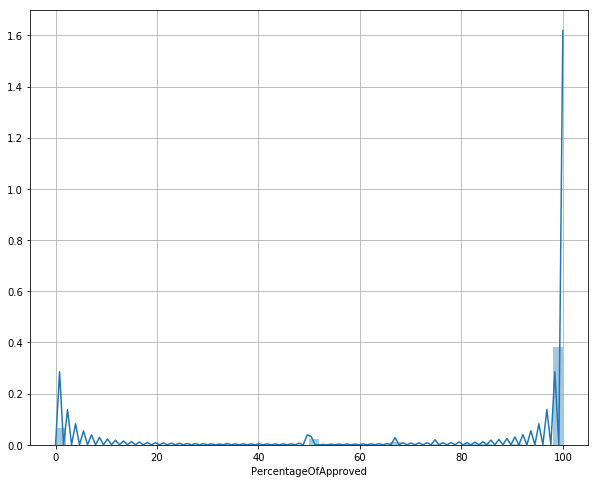

In [29]:
plt.figure(figsize=(10,8))
sns.distplot(df_submitted_vs_approved['PercentageOfApproved'])
plt.grid()
plt.show()

Text(0.5,1,'Correlation between Projects Approved vs Projects Submitted by a Teacher')

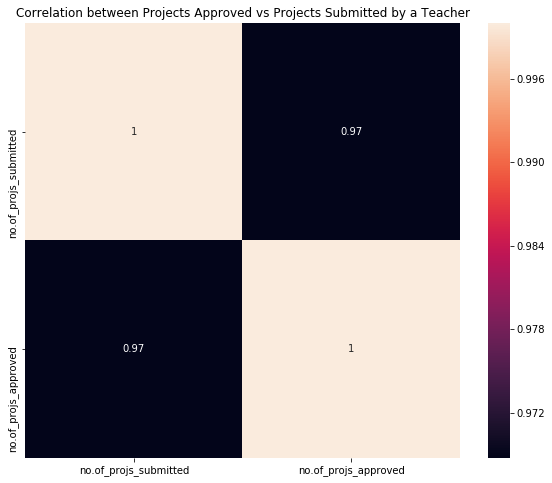

In [30]:
correlation = df_submitted_vs_approved[['no.of_projs_submitted','no.of_projs_approved']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True, square=True)
plt.title('Correlation between Projects Approved vs Projects Submitted by a Teacher')


In [31]:
df_submitted_vs_approved['PercentageOfApproved'] = df_submitted_vs_approved['PercentageOfApproved'].astype(int)

In [32]:
count_at_that_percentage = df_submitted_vs_approved['PercentageOfApproved'].value_counts()

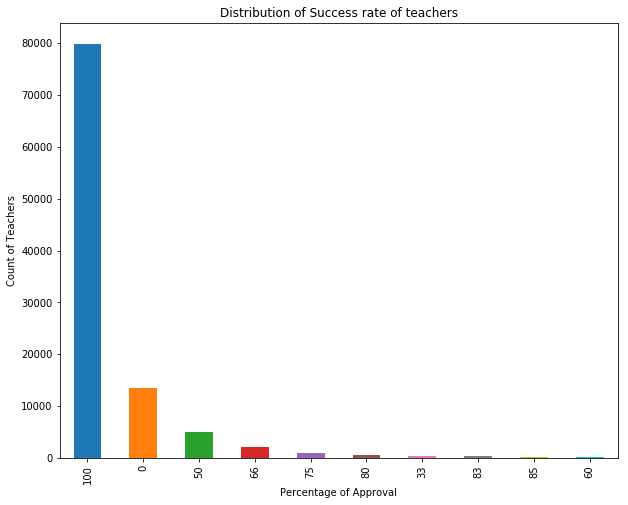

In [33]:
plt.figure(figsize=(10,8))
count_at_that_percentage.head(10).plot(kind='bar')
plt.title('Distribution of Success rate of teachers')
plt.xlabel('Percentage of Approval')
plt.ylabel('Count of Teachers')
plt.show()

Explanation: We have calculated, Teacher wise "projects_approved/projects_submitted percentage" then performed Groupby on Percentage calculated to get the insights of success rate of teacher wise projects Approval.

In [34]:
count_at_that_percentage.head()

100    79870
0      13410
50      5047
66      2103
75       994
Name: PercentageOfApproved, dtype: int64

In [35]:
print('Percentage of Teachers who has Success rate of 100% is: ',(count_at_that_percentage.head(1)/count_at_that_percentage.sum()).values[0] * 100)
print('Percentage of Teachers who has Success rate of 0%',(count_at_that_percentage[1:2]/count_at_that_percentage.sum()).values[0]*100)

Percentage of Teachers who has Success rate of 100% is:  76.49357365870478
Percentage of Teachers who has Success rate of 0% 12.843105330702778


> Observation: We can see that around __79870 (~76%)__ of Teachers has __Success Rate of 100%__ followed by 13410 (~13%) of the teachers has Success Rate of 0%. 

### Teacher Prefix wise Submissions

In [36]:
teacher_prefix_wise_count = train_df['teacher_prefix'].value_counts()
teacher_prefix_wise_count = (teacher_prefix_wise_count/teacher_prefix_wise_count.sum())*100

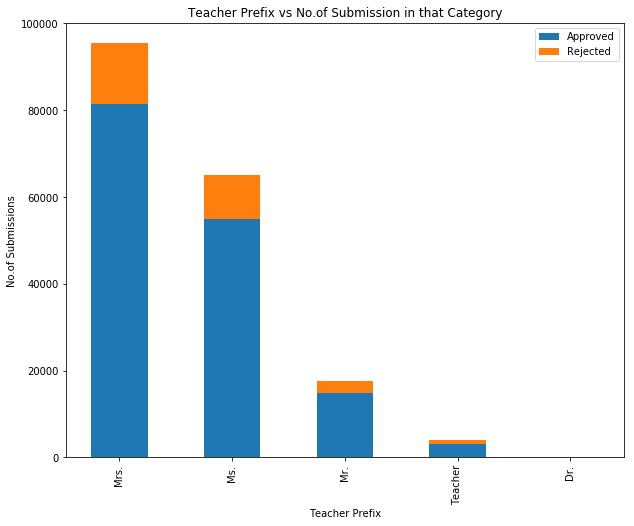

In [147]:
width = 0.5       
N = np.arange(5)
teacher_prefix_wise_count = train_df['teacher_prefix'].value_counts()
#teacher_prefix_wise_count = (teacher_prefix_wise_count/teacher_prefix_wise_count.sum())*100
teacher_prefix_wise_count_approved = []
teacher_prefix_wise_count_rejected = []

for teacher in teacher_prefix_wise_count.index:
    teacher_prefix_wise_count_approved.append(np.sum(train_df["project_is_approved"][train_df["teacher_prefix"]==teacher] == 1))
    teacher_prefix_wise_count_rejected.append(np.sum(train_df["project_is_approved"][train_df["teacher_prefix"]==teacher] != 1))

    
plt.figure(figsize=(10,8))    
bar1 = plt.bar(N, teacher_prefix_wise_count_approved[0:5], width)
bar2 = plt.bar(N, teacher_prefix_wise_count_rejected[0:5], width,
             bottom=teacher_prefix_wise_count_approved[0:5])


plt.xticks(N,teacher_prefix_wise_count.index,rotation=90)

plt.title('Teacher Prefix vs No.of Submission in that Category')
plt.xlabel('Teacher Prefix')
plt.ylabel('No.of Submissions')

plt.legend((bar1[0], bar2[0]), ('Approved', 'Rejected'))

plt.show()

In [179]:
print('Percentage of Prefix "Mrs": ',(teacher_prefix_wise_count.head(1).sum()/teacher_prefix_wise_count.sum())*100)
print('Percentage of Women i.e with Prefix "Mrs, Ms": ',(teacher_prefix_wise_count.head(2).sum()/teacher_prefix_wise_count.sum())*100)
print('Percentage of Approval with prefix "Mrs": ',(teacher_prefix_wise_count_approved[0]/teacher_prefix_wise_count[0].sum())*100)

Percentage of Prefix "Mrs":  52.39844899931897
Percentage of Women i.e with Prefix "Mrs, Ms":  88.13407588040158
Percentage of Approval with prefix "Mrs":  85.40852156595567


> Observation: From the above stats we can see that Most of the submissions are from __Women with 88%__, Highest approval rate is 85.40 with Prefix Category 'Mrs' followed by 'Ms'.

### School Grade wise Project submissions

In [38]:
grade_wise_count = train_df['project_grade_category'].value_counts()
# Converting Counts to percentages
grade_wise_count = (grade_wise_count/grade_wise_count.sum()*100)

In [180]:
grade_wise_count

Grades PreK-2    40.581063
Grades 3-5       33.876318
Grades 6-8       15.486050
Grades 9-12      10.056569
Name: project_grade_category, dtype: float64

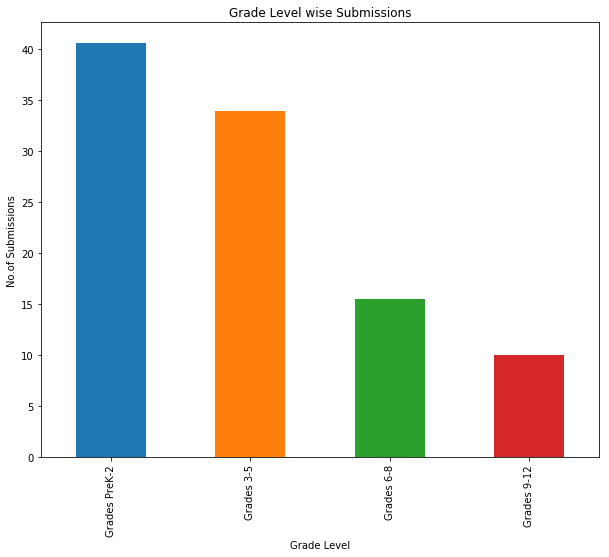

In [39]:
plt.figure(figsize=(10,8))
grade_wise_count.head(4).plot(kind='bar')
plt.title('Grade Level wise Submissions')
plt.xlabel('Grade Level')
plt.ylabel('No.of Submissions')
plt.show()

> Observation: As Grade Level increases No.of Project Proposals Decreases

### Resource Quantity Distribution 

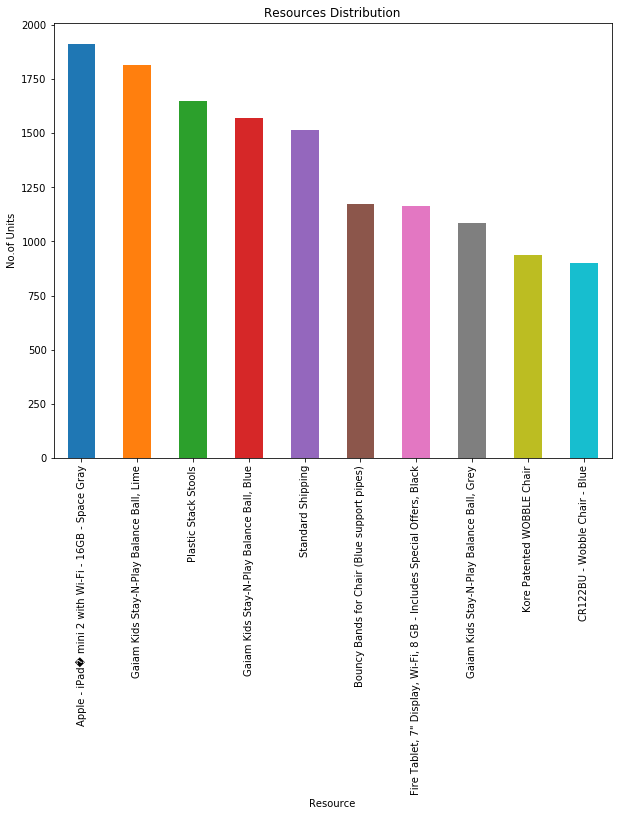

In [175]:

resource_req_count = train_res_df['description'].value_counts()
plt.figure(figsize=(10,8))
resource_req_count.head(10).plot(kind='bar')
plt.title('Resources Distribution')
#Reducing the length of the description
top_10_resource_names = list(resource_req_count.index[0:10])
top_10_resource_names[2] = 'Plastic Stack Stools'
top_10_resource_names[8] = 'Kore Patented WOBBLE Chair'
plt.xticks(np.arange(10),top_10_resource_names)
plt.xlabel('Resource')
plt.ylabel('No.of Units')
plt.ticklabel_format()

plt.show()

> Observation: Among all the resources, Most requested Resource is __Apple iPad mini 2__

In [159]:
import re
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = SYMBOLS_RE.sub('',text)# delete symbols which are in SYMBOLS_RE from text    
    cleaned = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in cleaned:
        new_text +=i+' '
    text = new_text
    return text.strip()

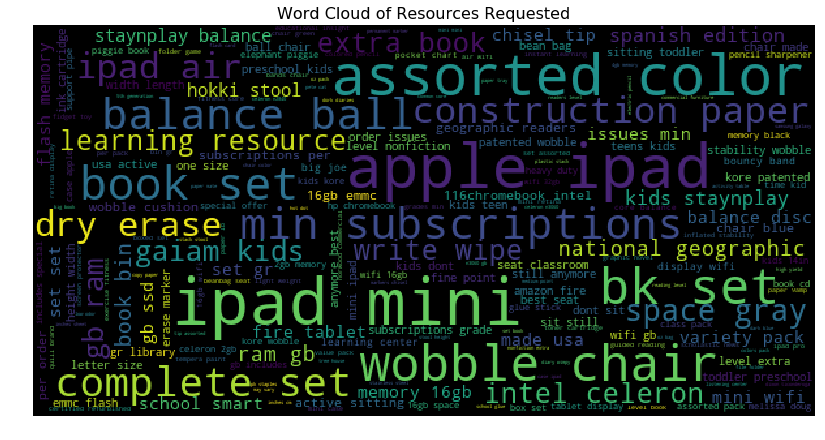

In [160]:
temp_data = train_res_df.dropna(subset=['description'])
# converting into lowercase
temp_data['description'] = temp_data['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['description'] = temp_data['description'].map(text_prepare)


from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['description'].values))
plt.figure(figsize=(14,8))
plt.imshow(wordcloud)
plt.title("Word Cloud of Resources Requested", fontsize=16)
plt.axis("off")
plt.show() 

### WordCloud of Important Features/Words from Project Essay

In [46]:
train_df['about_project'] = train_df[['project_essay_1', 'project_essay_2']].apply(lambda x: ' '.join(x), axis=1)

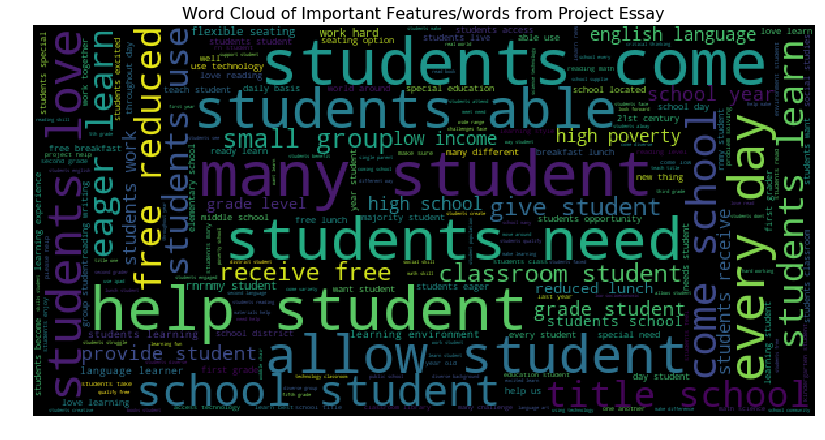

In [49]:
temp_data = train_df.dropna(subset=['about_project'])
# converting into lowercase
temp_data['about_project'] = temp_data['about_project'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['about_project'] = temp_data['about_project'].map(text_prepare)


from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['about_project'].values))
plt.figure(figsize=(14,8))
plt.imshow(wordcloud)
plt.title("Word Cloud of Important Features/words from Project Essay", fontsize=16)
plt.axis("off")
plt.show() 

# Data Preprocessing

## Lets Remove unnecessary Features

In [64]:
train_res_df = train_res_df.sort_values(by=['project_submitted_datetime'])

In [66]:
train_res_df['Price'] = train_res_df['quantity']*train_res_df['price']

In [67]:
train_res_df = train_res_df.drop(['quantity','price'],axis=1)

In [83]:
'''pickle_out=open("beforeFeatures_Removal.pickle","wb")
pickle.dump(train_res_df,pickle_out)
pickle_out.close()'''

In [68]:
train_res_dim_df = train_res_df.drop(['id','teacher_id','project_submitted_datetime','project_title','project_resource_summary','description'],axis=1)

## Lets Convert Categorical and text Features to Numerical Features

In [69]:
train_res_dim_df.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_essay_1,project_essay_2,teacher_number_of_previously_posted_projects,project_is_approved,Price
763814,Ms.,CA,Grades 6-8,Math & Science,Applied Sciences,I love giving my students experiences. A new e...,My students can vary quite dramatically. I hav...,30,1,596.00
1028203,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,9.99
1028198,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99
1028199,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99
1028200,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99


In our Data Set we have some categorical features like teacher_prefix, school_state,grade etc.. lets convert them to Numerical features

In [70]:
categorical_features = ['teacher_prefix','school_state','project_grade_category']

for feature in categorical_features:
    num = LabelEncoder()
    train_res_dim_df[feature] = num.fit_transform(train_res_dim_df[feature].astype('str'))

In [71]:
train_res_dim_df.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_essay_1,project_essay_2,teacher_number_of_previously_posted_projects,project_is_approved,Price
763814,3,4,1,Math & Science,Applied Sciences,I love giving my students experiences. A new e...,My students can vary quite dramatically. I hav...,30,1,596.00
1028203,3,43,3,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,9.99
1028198,3,43,3,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99
1028199,3,43,3,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99
1028200,3,43,3,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99


> Observation: As we can see The Categorical Features are converted to numerical Features

### Lets Combine project_subject_categories and subcategories

In [72]:
train_res_dim_df['project_subject'] = train_res_dim_df[['project_subject_categories','project_subject_subcategories']].apply(lambda a : ' '.join(a),axis=1)

In [73]:
train_res_dim_df = train_res_dim_df.drop(['project_subject_categories','project_subject_subcategories'],axis=1)
train_res_dim_df['project_subject'].head()

763814                       Math & Science Applied Sciences
1028203    Literacy & Language, Math & Science Foreign La...
1028198    Literacy & Language, Math & Science Foreign La...
1028199    Literacy & Language, Math & Science Foreign La...
1028200    Literacy & Language, Math & Science Foreign La...
Name: project_subject, dtype: object

#### Lets Convert Project Subject into word vector

In [74]:
#considering only unigrams as text contains less no.of words
tfidf_vect = TfidfVectorizer(ngram_range=(1,1))

proj_subject_vector = tfidf_vect.fit_transform(train_res_dim_df['project_subject'])

In [75]:
proj_subject_vector.shape

(1073254, 52)

### Lets Combine Project essay 1 and Project essay 2

In [76]:
train_res_dim_df['about_project'] = train_res_dim_df[['project_essay_1', 'project_essay_2']].apply(lambda x: ' '.join(x), axis=1)

In [77]:
train_res_dim_df = train_res_dim_df.drop(['project_essay_1','project_essay_2'],axis=1)

#### Lets Clean the Text

In [78]:
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [79]:
start = datetime.now()
i=0
str1=' '
final_string=[]
stop = set(stopwords.words('english'))

for sent in train_res_dim_df['about_project'].values:
    filtered_sentence=[]
    
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower())    
                else:
                    continue
            else:
                continue 
    
    #final string of cleaned words
    str1 = " ".join(filtered_sentence) 
   
    
    final_string.append(str1)
    i+=1
    if(i%10000==0):
        print("No of Sentences processed: ",i)
print("Time Taken To Clean the data is: ",datetime.now() -start)

No of Sentences processed:  10000
No of Sentences processed:  20000
No of Sentences processed:  30000
No of Sentences processed:  40000
No of Sentences processed:  50000
No of Sentences processed:  60000
No of Sentences processed:  70000
No of Sentences processed:  80000
No of Sentences processed:  90000
No of Sentences processed:  100000
No of Sentences processed:  110000
No of Sentences processed:  120000
No of Sentences processed:  130000
No of Sentences processed:  140000
No of Sentences processed:  150000
No of Sentences processed:  160000
No of Sentences processed:  170000
No of Sentences processed:  180000
No of Sentences processed:  190000
No of Sentences processed:  200000
No of Sentences processed:  210000
No of Sentences processed:  220000
No of Sentences processed:  230000
No of Sentences processed:  240000
No of Sentences processed:  250000
No of Sentences processed:  260000
No of Sentences processed:  270000
No of Sentences processed:  280000
No of Sentences processed:  2

In [80]:
train_res_dim_df['cleaned_about_project'] = final_string

In [81]:
train_res_dim_df.head()

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,Price,project_subject,about_project,cleaned_about_project
763814,3,4,1,30,1,596.00,Math & Science Applied Sciences,I love giving my students experiences. A new e...,love giving students experiences new experienc...
1028203,3,43,3,1,1,9.99,"Literacy & Language, Math & Science Foreign La...","We are getting closer to the end of the year, ...",getting closer end year still lot work get don...
1028198,3,43,3,1,1,29.99,"Literacy & Language, Math & Science Foreign La...","We are getting closer to the end of the year, ...",getting closer end year still lot work get don...
1028199,3,43,3,1,1,29.99,"Literacy & Language, Math & Science Foreign La...","We are getting closer to the end of the year, ...",getting closer end year still lot work get don...
1028200,3,43,3,1,1,29.99,"Literacy & Language, Math & Science Foreign La...","We are getting closer to the end of the year, ...",getting closer end year still lot work get don...


In [82]:
'''pickle_out=open("cleanedData.pickle","wb")
pickle.dump(proj_subject_vector,pickle_out)
pickle.dump(final_string,pickle_out)
pickle.dump(train_res_dim_df,pickle_out)
pickle_out.close()'''

In [2]:
pickle_in=open("cleanedData.pickle","rb")
proj_subject_vector = pickle.load(pickle_in)
final_string = pickle.load(pickle_in)
train_res_dim_df = pickle.load(pickle_in)
pickle_in.close()

In [11]:
proj_subject_vector

<1073254x52 sparse matrix of type '<class 'numpy.float64'>'
	with 4683669 stored elements in Compressed Sparse Row format>

In [8]:
'''pickle_out=open("projSubjVector.pickle","wb")
pickle.dump(proj_subject_vector,pickle_out)
pickle_out.close()'''

In [3]:
pickle_in=open("projSubjVector.pickle","rb")
proj_subject_vector = pickle.load(pickle_in)

pickle_in.close()

#### Lets Convert 'about project' into word vector

In [8]:
start = datetime.now()
#considering bigrams
tfidf_bigram_vect = TfidfVectorizer(ngram_range=(1,2))

about_proj_vector = tfidf_bigram_vect.fit_transform(train_res_dim_df['cleaned_about_project'][0:600000])
print("Time Taken: ",datetime.now() -start)

Time Taken:  0:02:49.768380


In [10]:
about_proj_vector.shape

(600000, 2273955)

In [12]:
'''pickle_out=open("tfidf_vect_projEssay_30000dp.pickle","wb")
pickle.dump(train_res_dim_df,pickle_out)
pickle.dump(about_proj_vector,pickle_out)
pickle.dump(proj_subject_vector,pickle_out)
pickle_out.close()'''

In [13]:
#del train_res_dim_df,about_proj_vector,proj_subject_vector

In [5]:
pickle_in=open("tfidf_vect_projEssay_30000dp.pickle","rb")
train_res_dim_df = pickle.load(pickle_in)
about_proj_vector = pickle.load(pickle_in)
proj_subject_vector = pickle.load(pickle_in)
pickle_in.close()

In [11]:
train_res_dim_df = train_res_dim_df[0:600000]

In [12]:
scaler = StandardScaler()
features = ['teacher_prefix','school_state', 'project_grade_category','teacher_number_of_previously_posted_projects', 'Price']

for feature in features:
    train_res_dim_df[feature] = scaler.fit_transform(train_res_dim_df[feature].astype(np.float64).values.reshape(-1, 1))


# Machine Learning Models

### Features Considered
<ul>
    <li>Teacher Prefix</li>
    <li>School State</li>
    <li>Project Grade Category</li>
    <li>Teacher no.of Previously posted Projects</li>
    <li>Price</li>
    <li>Project Subject(tfidf vector)</li>
    <li>Project Essays(tfidf vector)</li>
</ul>

### Datapoints Considered
-> 600000(6 lakhs) out of 1000000(~10 lakhs) datapoints

### Considered ML Models
#### LightGBM with GBDT,  RF with Logloss
-> As it is very suitable for large amount of data, unlike other boosting algorithms LGB grows the tree leaf wise(so that loss will be less), where as other algo(XGB) grows level wise.

#### XGB
-> SKLearn's implementation is taking huge amount of time, so used XGB.Train, its very fast when compared to SKLearn's implimentation.

In [ ]:
X = hstack((train_res_dim_df[['teacher_prefix', 'school_state', 'project_grade_category',
       'teacher_number_of_previously_posted_projects',
       'Price']],proj_subject_vector[0:600000],about_proj_vector))

In [14]:
X = X.tocsr()

In [15]:
Y = train_res_dim_df['project_is_approved'].to_sparse().as_matrix()

In [50]:
'''pickle_out=open("train_test_Split_data.pickle","wb")
pickle.dump(X,pickle_out)
pickle.dump(Y,pickle_out)
pickle_out.close()'''

In [2]:
'''pickle_in=open("train_test_Split_data.pickle","rb")
X = pickle.load(pickle_in)
Y = pickle.load(pickle_in)
pickle_in.close()'''

In [18]:
x_train = X[0:550000]
x_test = X[550000:600000]

In [19]:
y_train = Y[0:550000]
y_test = Y[550000:600000]

In [21]:
y_train.sum()/y_train.shape[0]

0.7809036363636364

In [182]:
def confusionMatrix(y_test,pred):
    df_cm = pd.DataFrame(confusion_matrix(y_test, pred), index = ['False','True'],
                      columns = ['False','True'])
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True,fmt='d')
    
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.figure(figsize=(12,10))
    plt.show()
def auc_roc(y_test,pred):
    fpr, tpr, thresholds = roc_curve(y_test,pred)
    acc = roc_auc_score(y_test,pred)
    print("Area Under The Curve is : ",acc)
    
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='darkorange',
              label='ROC curve (area/auc = %0.2f)' % acc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## LGB with GBDT Logloss

In [183]:
def train_lgb(boosting_type='gbdt',max_depth=7,num_leaves=32,learning_rate=0.02,n_iter=1000,early_stopping_rounds=25,verbose_eval=25):
    params = {
        'boosting_type': boosting_type,
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
        
    }  
    evals_result = {}  # to record eval results for plotting
    model_lgb = lgb.train(
            params,
            lgb.Dataset(x_train, y_train),
            num_boost_round=n_iter,
            valid_sets=[lgb.Dataset(x_test, y_test)],
            early_stopping_rounds=early_stopping_rounds,
            evals_result=evals_result,
            verbose_eval=verbose_eval)
    return model_lgb

In [184]:
def eval_model(model,x_test,y_test):
    y_preds = model_lgb.predict(x_test, num_iteration=model.best_iteration)
    pred = [1 if i>=0.56 else 0 for i in y_preds]
    confusionMatrix(y_test,pred)
    auc_roc(y_test,y_preds)
    print(roc_auc_score(y_test, y_preds))

In [33]:
'''pickle_out=open("lgb_73_auc.pickle","wb")
pickle.dump(model_lgb,pickle_out)
pickle.dump(evals_result,pickle_out)
pickle.dump(x_train,pickle_out)
pickle.dump(y_train,pickle_out)
pickle.dump(x_test,pickle_out)
pickle.dump(y_test,pickle_out)
pickle_out.close()'''

In [185]:
pickle_in=open("lgb_73_auc.pickle","rb")
model_lgb = pickle.load(pickle_in)
evals_result = pickle.load(pickle_in)
x_train = pickle.load(pickle_in)
y_train = pickle.load(pickle_in)
x_test = pickle.load(pickle_in)
y_test = pickle.load(pickle_in)
pickle_in.close()

In [186]:
model_5 = train_lgb(max_depth=15,num_leaves=34)

Training until validation scores don't improve for 25 rounds.
[25]	valid_0's auc: 0.688052
[50]	valid_0's auc: 0.693504
[75]	valid_0's auc: 0.700195
[100]	valid_0's auc: 0.705473
[125]	valid_0's auc: 0.709644
[150]	valid_0's auc: 0.713047
[175]	valid_0's auc: 0.717415
[200]	valid_0's auc: 0.719261
[225]	valid_0's auc: 0.721231
[250]	valid_0's auc: 0.72407
[275]	valid_0's auc: 0.725705
[300]	valid_0's auc: 0.727213
[325]	valid_0's auc: 0.728402
[350]	valid_0's auc: 0.729505
[375]	valid_0's auc: 0.730306
[400]	valid_0's auc: 0.731149
[425]	valid_0's auc: 0.732164
[450]	valid_0's auc: 0.732902
[475]	valid_0's auc: 0.733736
[500]	valid_0's auc: 0.734451
[525]	valid_0's auc: 0.734991
[550]	valid_0's auc: 0.735491
[575]	valid_0's auc: 0.735616
[600]	valid_0's auc: 0.73611
[625]	valid_0's auc: 0.736115
Early stopping, best iteration is:
[615]	valid_0's auc: 0.736214


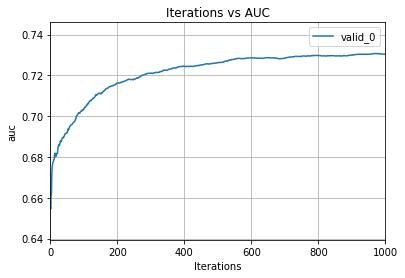

In [208]:
lgb.plot_metric(evals_result, metric='auc')
plt.title('Iterations vs AUC')
plt.show()

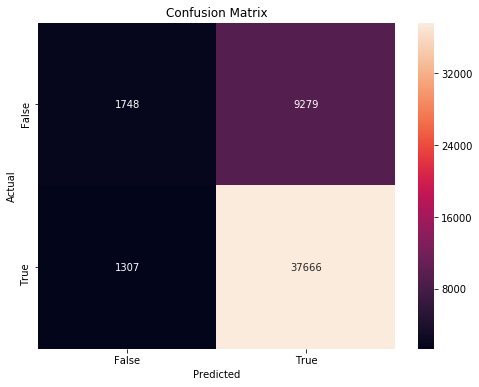

<Figure size 864x720 with 0 Axes>

Area Under The Curve is :  0.7362143395327896


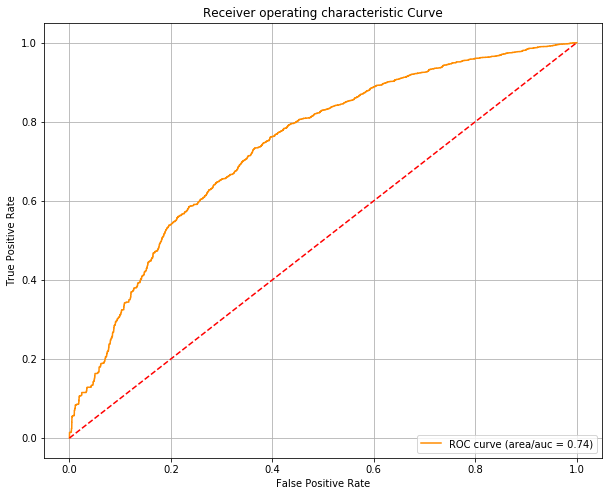

0.7362143395327896


In [100]:
eval_model(model_5,x_test,y_test)

## XGBOOST

In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
xgb_params = {'eta': 0.2,  #learning_rate
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic',  #logloss
                  'eval_metric': 'auc', 
                  'seed': 1234
                 }

d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_test, y_test)


#watchlist -> List of items to be evaluated during training, this allows user to watch performance on the validation set.
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model_xgb = xgb.train(xgb_params, d_train, 200, watchlist, verbose_eval=50, early_stopping_rounds=5)

xgb_pred_valid = model_xgb.predict(d_valid)
auc = roc_auc_score(y_test, xgb_pred_valid)
print('AUC:',auc)

[13:39:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-auc:0.663331	valid-auc:0.652078
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 5 rounds.
[13:39:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[13:39:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[13:39:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[13:39:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[13:40:01] C:\Users\Administrator\Desktop\xgboost\src\tree\up

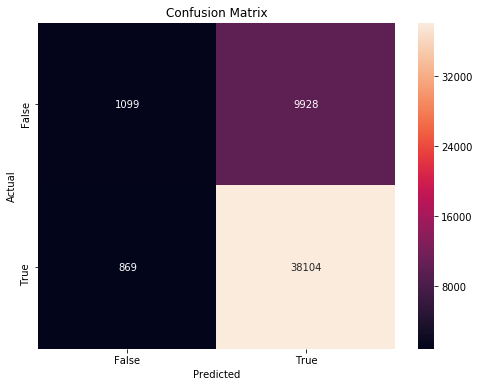

<Figure size 864x720 with 0 Axes>

In [43]:
pred = [1 if i>=0.56 else 0 for i in xgb_pred_valid]
confusionMatrix(y_test,pred)

Area Under The Curve is :  0.712009960431643


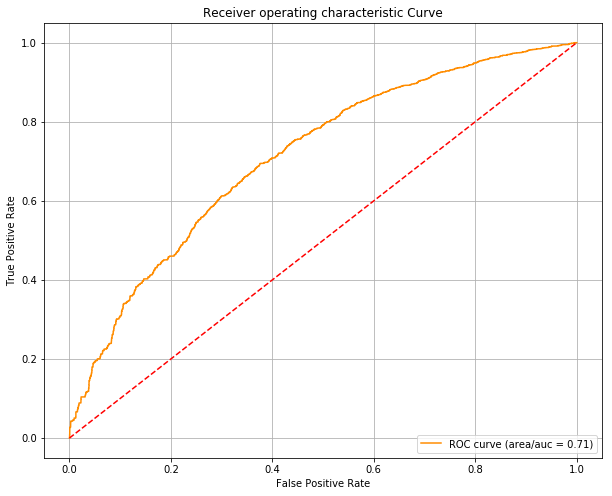

In [49]:
auc_roc(y_test,xgb_pred_valid)

> Observation: auc is 71% with max_depth of 5.

# Summary:

## Data Science
- Considered Training data for Analysis
- Data is Highly __Imbalanced__ i.e __~80%__ of data belongs to class 1(i.e Approved)
- Performed Data Cleaning
- Visualized the data using various types of plots to get the insights of the data.
- Some of the Observations/Conclusions:
    - __Max no.of projects__ posted by a Teacher is __45__.
    - Max no.of Submessions are from __California(CA)__
    - Max no.of Submessions are recorded in __Literacy & Language__ Project Category with __21%__ of which __87%__ were __Approved__
    - Around __9%__ of Submissions recorded from __Literacy__ Project SubCategory which Stood first among other SubCategories.
    - Around __76%__ of Teachers has __Success rate__ of __100%__, followed by __13%__ with __0 Success Rate__
    - Most of the Submissions are from __Married Women__ Teachers with contribution of __52%__ and has Highest Approval Percentage(__85%__) than other Prefixs.
    - Project Proposals are very high from Women than Men, with __88%__ Contribution from __Women__. 
    - Teachers with prefix __Dr__ has shown very less interest in Project Proposals with contribution percentage of __0.014%__.
    - Around __41%__ of Project proposals are for __Grades PreK-2__
    - __Higher Grades__ has __less__ no.of Project __Proposals__
    - Most __Trending/Requested Resource__ is __Apple iPad Mini 2 with WiFi 16GB Spacy Gray__ followed by __Galam kids Stay-N-Play Balance Ball__
    
    
    
## Machine Learning
- Done Data Preprocessing i.e removed unnecessary columns/features, converted Categorical Features to Numerical Features, Sentences to vectors(using tfidf vectorizer).
- Standardized the data.
- Total Data Points Considered __600000__ out of __1000000__
    - Train data points __550000__
    - Test data points __50000__
- Machine Learning Models used:
    - __Light Gradient Boost with LogLoss__
    - __XGBoost with LogLoss__
- Validation Metric used:
    - __AUC__
- Tuned HyperParameters:
    - LGB:
        - max_depth
        - num_leaves
        - learning_rate
    - XGBoost:
        - eta
        - max_depth
- Best Result Achieved using __LGB__ with __74% AUC__ 